In [1]:
import pandas as pd
import random
import math

data = pd.read_csv('~/ctgan/data/non_annualized_SD_max_rounded_yields.csv')
data.head()

,Yield (tons/acre),Total Radiation (W/m^2),Total Rainfall (mm),Avg Min Temp (C),Avg Max Temp (C)
0,5,132123.53,966.71,2.559024,14.859927
1,5,132123.53,966.71,2.559024,14.859927
2,5,132123.53,966.71,2.559024,14.859927
3,5,132123.53,966.71,2.559024,14.859927
4,5,132123.53,966.71,2.559024,14.859927


In [2]:
# from sdv.tabular import CTGAN

# model = CTGAN()
# model.fit(data)

samples_out = 20000 # total number of samples/records to generate/synthesize
no_stds = .5 # number of standard deviations within which synthesized values must fall
#F = data[["Total Radiation (W/m^2)","Total Rainfall (mm)", "Avg Max Temp (C)", "Avg Min Temp (C)"]] # the input feature matrix
number_of_classes = (data['Yield (tons/acre)'].unique()).size # number of unique classes in input data
F = [] # a list of the feature vectors dataframes, one per class
for class_no in range(number_of_classes):
    df = pd.DataFrame(data[data['Yield (tons/acre)'] == class_no])
    F.append(df)


def synthesize_tabular_data(samples_out, no_stds, F, no_classes, no_records):
    new_F = []
    for index, entry in enumerate(F):
        total_rad = entry['Total Radiation (W/m^2)']
        mean_rad = total_rad.mean()
        std_rad = total_rad.std()
        total_rain = entry['Total Rainfall (mm)']
        mean_rain = total_rain.mean()
        std_rain = total_rain.std()
        avg_max_temp = entry['Avg Max Temp (C)']
        mean_max_temp = avg_max_temp.mean()
        std_max_temp = avg_max_temp.std()
        avg_min_temp = entry['Avg Min Temp (C)']
        mean_min_temp = avg_min_temp.mean()
        std_min_temp = avg_min_temp.std()
        
        new_rads = []
        new_rains = []
        new_max_temps = []
        new_min_temps = []
        
        # calculate potcii: percentage of this class in input
        potcii = (len(entry)/no_records)
        no_records_to_generate = round(potcii * samples_out)
        
        for i in range(no_records_to_generate):
            new_rad = random.uniform(mean_rad - std_rad*no_stds, mean_rad + std_rad*no_stds)
            new_rads.append(new_rad)
            
            new_rain = random.uniform(mean_rain - std_rain*no_stds, mean_rain + std_rain*no_stds)
            new_rains.append(new_rain)
        
            new_max_temp = random.uniform(mean_max_temp - std_max_temp*no_stds, mean_max_temp + std_max_temp*no_stds)
            new_max_temps.append(new_max_temp)
            
            new_min_temp = random.uniform(mean_min_temp - std_min_temp*no_stds, mean_min_temp + std_min_temp*no_stds)
            new_min_temps.append(new_min_temp)
            
        concat_rads = pd.concat([total_rad, pd.DataFrame(new_rads)])
        concat_rain = pd.concat([total_rain, pd.DataFrame(new_rains)])
        concat_max_temps = pd.concat([avg_max_temp, pd.DataFrame(new_max_temps)])
        concat_min_temps = pd.concat([avg_min_temp, pd.DataFrame(new_min_temps)])
        new_df = pd.DataFrame()
        new_df['Total Radiation (W/m^2)'] = concat_rads
        new_df['Total Rainfall (mm)'] = concat_rain
        new_df['Avg Max Temp (C)'] = concat_max_temps
        new_df['Avg Min Temp (C)'] = concat_min_temps
        new_df['Yield (tons/acre)'] = index
        print(index)
        new_F.append(new_df)
        
    return pd.concat(new_F)

new_data = synthesize_tabular_data(samples_out, no_stds, F, number_of_classes, len(data.index))

0
1
2
3
4
5


In [3]:
#new_data = model.sample(2000)

In [4]:
new_data.to_csv('data/SITS_synth20k_0112_SD2OH_xgb_p5std.csv')
new_data.head()

,Total Radiation (W/m^2),Total Rainfall (mm),Avg Max Temp (C),Avg Min Temp (C),Yield (tons/acre)
2383,252578.57,1329.21,16.449559,2.79995,0
2384,252578.57,1329.21,16.449559,2.79995,0
2385,252578.57,1329.21,16.449559,2.79995,0
2386,252578.57,1329.21,16.449559,2.79995,0
2387,252578.57,1329.21,16.449559,2.79995,0


In [5]:
# get aggregate data
targetDataLoc = '~/ctgan/data/non_annualized_OH_max_rounded_yields.csv'
#aggDataLoc = 'data/synth1_GA_only_063022.csv'

aggDf = new_data #pd.read_csv(aggDataLoc)
#aggDf = aggDf.drop("Unnamed: 0",axis=1)
targetDf = pd.read_csv(targetDataLoc)
#targetDf = targetDf.drop("Unnamed: 0",axis=1)

In [6]:
############## imports
# general
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score  
# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVR  # support vector machines regression
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.neural_network import MLPClassifier # neural network for classification
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # adaboost for classification
import xgboost as xgb
# saving models
# from sklearn.externals import joblib
import joblib

# import the API
APILoc = 'API/'

import sys
sys.path.insert(0, APILoc)

from API import *

In [7]:
# filter out the features that will not be used by the machine learning models

# the features to keep:
# xColumnsToKeep = ["Julian Day", "Time Since Sown (Days)", "Time Since Last Harvest (Days)", "Total Radiation (MJ/m^2)",
#                "Total Rainfall (mm)", "Avg Air Temp (C)", "Avg Min Temp (C)", "Avg Max Temp (C)",
#                  "Avg Soil Moisture (%)", "Day Length (hrs)"], "Percent Cover (%)"]

xColumnsToKeep = ["Total Radiation (W/m^2)","Total Rainfall (mm)", "Avg Max Temp (C)", "Avg Min Temp (C)"]


#xColumnsToKeep = ["Julian Day", "Time Since Sown (Days)", "Total Radiation (MJ/m^2)", "Total Rainfall (mm)"]

# the target to keep
yColumnsToKeep = ["Yield (tons/acre)"]

# get a dataframe containing the features and the targets
xDf = aggDf[xColumnsToKeep]
test_xDf = targetDf[xColumnsToKeep]
yDf = aggDf[yColumnsToKeep]
test_yDf = targetDf[yColumnsToKeep]

# reset the index
xDf = xDf.reset_index(drop=True)
yDf = yDf.reset_index(drop=True)
test_xDf = test_xDf.reset_index(drop=True)
test_yDf = test_yDf.reset_index(drop=True)

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)

xCols = list(xDf)

In [8]:
# hide the warnings because training the neural network caues lots of warnings.
import warnings
warnings.filterwarnings('ignore')

# make the parameter grids for sklearn's gridsearchcv
rfParamGrid = {
        'model__n_estimators': [5, 10, 25, 50, 100], # Number of estimators
        'model__max_depth': [5, 10, 15, 20], # Maximum depth of the tree
        'model__criterion': ["mae"]
    }
knnParamGrid ={
        'model__n_neighbors':[2,5,10],
        'model__weights': ['uniform', 'distance'],
        'model__leaf_size': [5, 10, 30, 50]    
    }
svrParamGrid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 1.0, 5.0, 10.0],
        'model__gamma': ["scale", "auto"],
        'model__degree': [2,3,4,5]
    }
nnParamGrid = {
        'model__hidden_layer_sizes':[(3), (5), (10), (3,3), (5,5), (7,7)],
        'model__solver': ['sgd', 'adam'],
        'model__learning_rate' : ['constant', 'invscaling', 'adaptive'],
        'model__learning_rate_init': [0.1, 0.01, 0.001]      
    }

linRegParamGrid = {}

bayesParamGrid={
        'model__n_iter':[100,300,500]
    }

dtParamGrid = {
    'model__criterion': ['mae'],
    'model__max_depth': [5,10,25,50,100]
    }

xgbParamGrid = {}

aModelList = [#(RandomForestRegressor(), rfParamGrid, "rfTup.pkl"),
              #(KNeighborsRegressor(), knnParamGrid, "knnTup.pkl"),
              #(SVR(), svrParamGrid, "svrTup.pkl"),
             #(MLPClassifier(), nnParamGrid, "nnTup.pkl")]#,
             #(LinearRegression(), linRegParamGrid, "linRegTup.pkl")]#,
             #(BayesianRidge(), bayesParamGrid, "bayesTup.pkl"),
             #(DecisionTreeRegressor(), dtParamGrid, "dtTup.pkl")]
             (xgb.XGBClassifier(), xgbParamGrid, "xgbTup.pkl")]

N = 10
workingDir = 'working_dir'
numFeatures = 4 # 11

model:  xgbTup
Avg MAE:  284.341
Avg R squared:  0.752
Best MAE:  273.253
Best R squared:  0.777
Parameters of the best model:  {}
Features selected by best model:  ['Total Radiation (W/m^2)', 'Total Rainfall (mm)', 'Avg Max Temp (C)', 'Avg Min Temp (C)']
Accuracy:  0.8660436137071651
f1 score:  0.8759184103256411
mcc:  0.774538251208632
 
test results on our test data: 


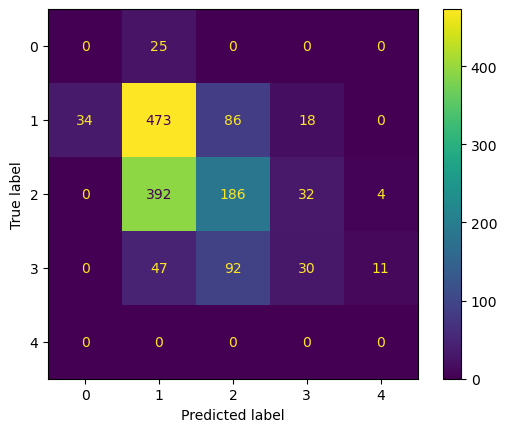

results:
MAE:  0.5664335664335665
R sq:  -0.3000386471020906
accuracy score for DA/TDA:  0.4818181818181818


In [9]:
saveMLResults(test_xDf, test_yDf, N, xDf, yDf, aModelList, workingDir, numFeatures, printResults=True)